# Support Vector Machines to predict stable crystal compositions

In this notebook you will work with three datafiles: SVMdata1.txt, SVMdata2.txt and SVMdata3.txt. They contain information about experiments of a three hypothetical materials: Simpilian, Complexian and Absurdian as function of their composition presented by coordinates (X1,X2). The material can either form a form a 'good' single homogeneous crystal (1) or have decomposed in a 'bad' poly-crystalline sample (-1). It is your task to find the boundary between these two phases based on a finite experimental dataset. The complexity of the decision boundary grows from example 1 to 3. The data is linearly separable in ex.1 and 2 by either a straight line or a curvy line, respectively. In example 3 you will encounter that the experimental data close to the decision boundary is diffuse or contains noise/errors.

## Part 1. The Genetic Algorithm

We are going to start by coding a general genetic algorithm that can be used to maximize an arbitrary fitness function. You will first test your code by maximizing 
$$f(\boldsymbol{\theta})=-(\theta_0-10)^2-(\theta_0-\theta_1)^2-(\theta_0-\theta_1-\theta_2-3)^2$$
This is maximisation is equivalent to the **minimisation** of the squared loss function:
$$loss(\boldsymbol{\theta})=(\theta_0-10)^2+(\theta_0-\theta_1)^2+(\theta_0-\theta_1-\theta_2-3)^2$$
__The jargon of 'maximisation of the fitness' is coming from the analogy to genetic eveloution, in which the fittest individuals have the largest chance to procreate. However, a formulation in terms of a minimisation are usualy perferable for ML. Note that here loss=-fitness, simply. For the sake of the analogy we will use the fitness here.__

Derive the solution analytically yourself. <em>Answer:</em> $\boldsymbol{\theta} =\{10,10,-3\}$. 



In [1]:
# importing the required modules
%pip install numpy matplotlib seaborn pandas scikit-learn #installs them if they are not yet there
import numpy as np 
import matplotlib.pyplot as plt
#import sklearn
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
#print('The scikit-learn version is {}.'.format(sklearn.__version__))

# to get matplot figures render correctly in the notebook use:
%matplotlib inline 

ERROR: Invalid requirement: '#installs'

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
def f(theta,C=1):
    """
    computes the fitness (-1* loss of individual with genome theta) according to the equation
    loss = (theta[0]-10)^2 + (theta[0]-theta[1])^2 + (theta[0]-theta[1]-theta[2]-3)^2 e

    Parameters
    ----------
    theta : (3,) ndarray of float (the genome of the individual)
    C: float: Optional number  scale the penalty in the fitness function [Ignore in this function!]
    
    Returns
    -------
    loss : float
        The loss of theta

    """
    '''YOUR CODE GOES HERE '''
    fitness = -(theta[0]-10)**2 - (theta[0]-theta[1])**2 - (theta[0]-theta[1]-theta[2]-3)**2

    return fitness

We define $K$ vectors $\boldsymbol{\theta}_k$, $k=0, \ldots, K-1$ that serve all as approximations of the real maximum. Every vector in this collection has a certain fitness $f_k = f(\boldsymbol{\theta}_k)$. We will apply a genetical algortithm in this notebook, in which each $\boldsymbol{\theta}_k$ is an **indiviual**.

For the time being assume these vectors are sorted according decreasing fitness. So $\boldsymbol{\theta}_0$ has the largest fitness $f_0$ and $\boldsymbol{\theta}_{K-1}$ the lowest fitness $f_{K-1}$. Genetically the vector $\boldsymbol{\theta}_0$ is stronger $\boldsymbol{\theta}_1$, etc.

After initializing a population with random **genomes** and sorting them according to fitness, we are going to generate a new population, again of size $K$. (You will see that there are quite some choices to be made in the sequal, but, strangely enough, it does not matter so much how you choose them: this genetic algorithm works 'all the time'.) 
We need two functions  `cross(theta1, theta2)` and   `mutate(theta)` in order to generate a new population.

- The function `cross(theta1, theta2)` combines individuals $theta1, theta2$, to a new genome/individual  
- The function `mutate(theta)` mutates individual $theta$


In [3]:
rng = np.random.default_rng()

def cross(theta1, theta2):
    """
    generates a new individual by crossing genes from individuals theta1 and theta2 
    by taking half the genes (randomly chosen) from theta1 and the others from theta2

    Parameters
    ----------
    theta1, theta2 : (N,) ndarray of float (N is the number of genes of the genomes)
        The two indivuals/genomes that will be crossed
    
    Returns
    -------
    crossed_theta : (N,) ndarray of float (N is the number of genes of the genomes)
        The new individual/genome

    """
    
    '''YOUR CODE GOES HERE '''

    l = len(theta1)
    crossed_theta = np.zeros(l)
    index = np.arange(l)
    #index_1 = np.random.choice(index, size=l//2, replace=False)
    index_1 = rng.choice(index, size=l//2, replace=False)
    
    for i in range(l):    
        if i in index_1:
            crossed_theta[i] = theta1[i]
                
        else:
            crossed_theta[i] = theta2[i]        
                
    return crossed_theta



def mutate(theta):
    """
    mutates an individual theta by adding a randomly chosen values to randomly chosen genes 

    Parameters
    ----------
    theta : (N,) ndarray of float (N is the number of genes of the individual)
        The individual/genome that gets mutated
    
    Returns
    -------
    mutated_theta : (N,) ndarray of float (N is the number of genes of the individual)
        The new individual/genome

    """

    '''YOUR CODE GOES HERE '''

    mutated_theta = theta.copy()
    fac=0.1
    l = len(theta)
    index = np.arange(l)
    #index_1 = np.random.choice(index, size=int(np.floor(l*0.8)), replace=False)
    index_1 = rng.choice(index, size=int(np.floor(l * 0.8)), replace=False)

    for i in range(l):    
        if i in index_1:
            mutated_theta[i] = theta[i] + np.random.normal(scale = fac*abs(theta[i]))
                
    return mutated_theta


In [4]:
#Test your mutate function on theta=np.ones(3)
mutate(np.ones(3))

array([1.        , 1.11039725, 1.05355183])

These functions allow us to combine genomes of individuals. We of course now need a strategy **which individuals** are going to take part in it. As a first attempt, lets test the following genetic algorithm:

As the individuals with a low index are strong, we let the strongest $25\%$ be part of the new population as well.

For the other $75\%$ we are going to combine the genomes of two parents, $A, B$, giving an individual (offspring) $C$ with  

| range | A: parent 1 | B: parent 2 | C: offspring |
|---|:---:|:---:|:-------------------------------------------------------------------------------:|
|$$\text{first }25\%$$ | none |  none | $$\boldsymbol{\theta}_k, \text{with }k=0..K/4-1$$ | 
|$$\text{second }25\%$$ | $$\boldsymbol{\theta}_k$$ | $$\boldsymbol{\theta}_{k+1}$$ | $$\text{cross(A,B) + mutate, } k=0..K/4-1$$ |
|$$\text{third } 25\%$$ | $$\boldsymbol{\theta}_k$$ | $$\boldsymbol{\theta}_r$$ | $$\text{cross(A,B) + mutate, } k=0..K/4-1, r \text{ is random}$$|  
|$$\text{fourth } 25\%$$ | $$\boldsymbol{\theta}_r$$ | $$\boldsymbol{\theta}_s$$ | $$\text{cross(A,B) + mutate, } r \text{ and } s \text{ taken random}$$ | 

For convenience we take $K$ to be a multiple of $4$, so it will be straightforward to split the population in the 4 groups. And again: change the rules and see if you can do better than my first attempt!

The resulting algorithm may seem to be slow. However, if the number of parameters becomes (much) larger the algorithm still works more or less at the same speed.

In [5]:
def cross_and_mutate(population):
    """
    generates a new population of individuals by crossing and mutating 

    Parameters
    ----------
    population : (K, N+1) ndarray of float (K is the number of individuals, N+1 is the number of genes of the individual)
        The population used to generate the new population. The population is assumed to be in order of fitness
    
    Returns
    -------
    offspring : (K, N+1) ndarray of float (see above)
        The new population

    """
    
    '''YOUR CODE GOES HERE '''
    ## pop describes the complete population: 
    K, N = population.shape
    offspring = np.zeros_like(population)
    
    for k in range(K):
        # copy best 25% from population
        if k < int(K/4):
            offspring[k,:] = population[k,:]
        
        # second 25%
        elif k < int(K/2):
            parent1 = population[k - int(K/4)]
            parent2 = population[k - int(K/4)+1]
            offspring[k] = cross(parent1,parent2)
        
        # third 25%
        elif k < int(3*K/4):
            parent1 = population[k - int(K/2)]
            parent2 = population[np.random.randint(K)]
            offspring[k] = cross(parent1,parent2)
        
        # final 25%
        else:
            offspring[k] = cross(population[np.random.randint(K)], population[np.random.randint(K)])

        
        ## next mutate
        if k >= int(K/4):
            offspring[k] = mutate(offspring[k])
        
    return offspring

In [6]:
def run(f, K, N, num_generations = 1000, C=1000):
    """
    executes the genetic algorithm to maximize a fitness function 

    Parameters
    ----------
    f: function:  returns a fitness value and has as argument an individual/genome (ndarray of shape (N,))
    K: integer : size of the population (multiple of 4)
    N: integer : number of genes in an individual
    num_generations: integer : number of generation that are executed
    C: float: Real optional number used in to scale the penalty in the fitness function
    
    Returns
    -------
    (theta, fitness_history): tuple
        theta: ndarray(N,) of float representing the individual.genome that yielded the best fitness
        fitness: ndarray(num_generations, ) of float the best fitness after each generation

    """
    
    '''YOUR CODE GOES HERE '''

    population = np.random.randn(K,N)
    fitness_history = np.zeros(num_generations)
    
    for generation in range(num_generations):  
        fitness_values = np.array([f(ind,C) for ind in population])
        
        # take best
        best_idx= np.argmax(fitness_values)
        best_fitness = fitness_values[best_idx]
        fitness_history[generation] = best_fitness
        
        # sort
        sorted_indices = np.argsort(fitness_values)[::-1]
        population=population[sorted_indices]
        
        # create new population
        population=cross_and_mutate(population)
            
    theta=population[0]
    return(theta, fitness_history)

[ 9.94371268  9.39235523 -2.31427551]


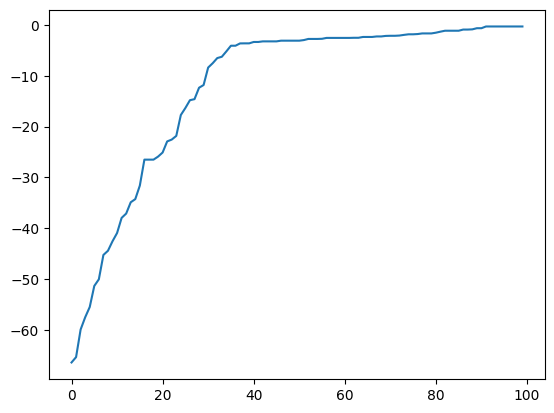

In [7]:
# execute the genetic algorithm
K =  80  # population size (~10-100)
N = 3  # number of genes in the genome
num_generations = 100

theta, fitness = run(f, K, N, num_generations)

print(theta)
plt.plot(fitness)  # plot the evolution of the fitness

This should converge to fitness = 0 best genome  $\boldsymbol{\theta} = [10, 10, -3]$

## Part 2. The Support Vector Machine


**We have now setup the algorithm and apply it to data sets:**

- The first we do by using a package **sklearn**. 
- Second, we will solve it by using the genetic algorithm. 
- Later on you will use the package **sklearn** on more difficult data sets (to write a code that does what **sklearn** can do will take many ECs....


The data sets below will be data in 2D with two types: $y=1$ and $y=-1$ . 

### Example Dataset 1: Material Simpilian

In [8]:
FILENAME = './SVMdata1.txt'  # points to the datafolder; either a relative or absolute path
DELIMITER = ','  # we use a lot of csv or txt files where the data is separated by a comma

data = np.loadtxt(FILENAME, delimiter=DELIMITER)
X1 = data[:,:2]
y1 = data[:,2]
print(X1.shape, y1.shape)

(51, 2) (51,)


In [9]:
# two plot functions are defined.
# one for plotting the data and the decision boundary and margins of the SVM solution
# one for plotting the data and the results from the SVM from sklearn

def plotdata(X, y, theta=None):
    """
    plots the data and optionally the decision boundary and margins 

    Parameters
    ----------
    X: ndarray of size (M, 2) : data, with M the number of samples and 2 features
    y: ndarray of size (M,) :  labels of the datapoints (either 1 or other)
    theta: ndarray(3,) : solution of the SVM decision boundary theta[0] = bias, theta[1] and theta[2] are the weights
                        if None (default) no baoundary is plotted
    
    Returns
    -------
    None
    """
    mask = y == 1
    plt.scatter(*X[mask,:].T, s=50, c='k', marker='+', label='1')
    plt.scatter(*X[~mask,:].T, s=50, c='y', marker='o', label='-1')
    
    # optionally plot decision boundary 
    if theta is not None:
        x = np.linspace(min(X[:,0]), max(X[:,0]), 10)
        b, w1, w2 = theta
        y_db = -w1 / w2 * x - b / w2  # see eq 4.5 reader
        # margins
        y_margin1 = y_db + 1 / w2  # see eq. 4.9 reader with gamma=1
        y_margin2 = y_db - 1 / w2
        plt.plot(x, y_db, label='decision boundary')
        plt.plot(x, y_margin1, ':r', label='margins')
        plt.plot(x, y_margin2, ':r')
        
    plt.legend()
    plt.xlabel('x1')
    plt.ylabel('x2')

    
def plot_svc(svc, X, y):
    """
    plots the results from the sklearn SVM fit

    Parameters
    ----------
    svc: instance of sklearn.svm._classes.SVC
    X: ndarray of size (M, 2) : data, with M the number of samples and 2 features
    y: ndarray of size (M,) :  labels of the datapoints (either 1 or other)
    
    Returns
    -------
    None
    """
    # first plot the data and decisionboundary
    plotdata(X, y)
    DecisionBoundaryDisplay.from_estimator(clf, X, ax=plt.gca(), alpha=0.4, cmap=plt.cm.Paired, response_method="predict")
 
    # plot the supportvectors
    plt.scatter(svc.support_vectors_[:,0], svc.support_vectors_[:,1], c='k', marker='|', s=100, linewidths=1)
    plt.title(f'C={svc.C}; Number of support vectors: {svc.support_.size}')    
   
    plt.xlabel('x1')
    plt.ylabel('x2')
    

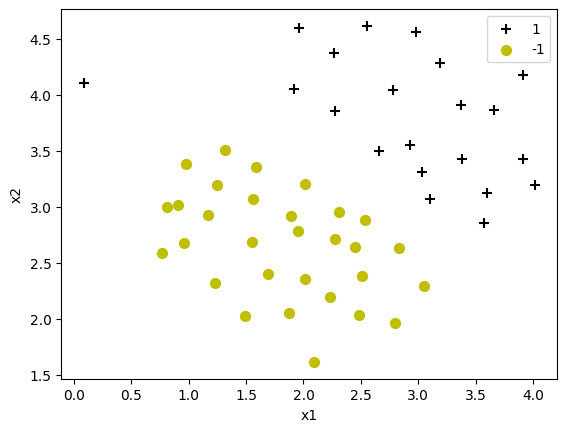

In [10]:
plotdata(X1, y1) 

We first make the data set a little simpler: the point on the left changes identity ($1 \to -1$)

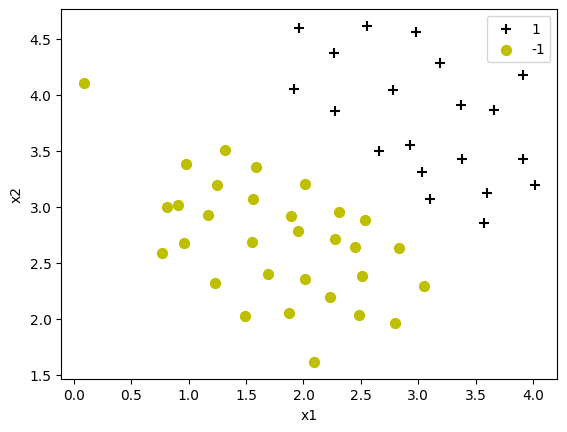

In [11]:
y1[50] = -1
plotdata(X1, y1)

This is what SVC from the package does. What is the function of the parameter C?

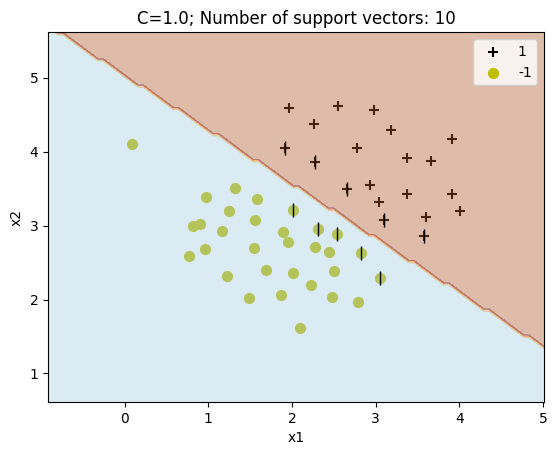

In [12]:
clf = SVC(C=1.0, kernel='linear')
clf.fit(X1, y1)
plot_svc(clf, X1, y1)

## Implement the SVM optimisation yourself.
**Implement the optimalisation as as defined below using the genetic algorith that we already have in the run() function. You can also find it in Eq. (4.12) of the lecture notes or (7.3) in Bishop.**

Find $\mathbf{w}$ and $b$ that maximize the margin, while correctly classify all data:<br>
  argmax$_{\mathbf{w},b} \left \{ \frac{1}{\| \mathbf{w} \|} \displaystyle \min_m \left \{ y^{(m)} \left ( \mathbf{w}^T \mathbf{x}^{(m)} + b \right) \right \} \right \},\;\; $
    $ \text{subject to }y^{(m)} \left ( \mathbf{w}^T \mathbf{x}^{(m)} + b \right) \geq 0$
    
What is the fitness when the hyperplane of your SVM does not properly classify all points? Add a penelaty term to the fitness function that adds a penealty of size C for each misclassification, or use the hinge loss function (this is the better choice).

$\color{orange}\text{Write your linear model as we did before}$, inclusing the bias $b$ in the $\boldsymbol{\theta}$:
$$y=\mathbf{x}^{\rm T}\boldsymbol{\theta} := \left ( \mathbf{w}^T \mathbf{x} + b \right)$$

In [32]:
def fSVM(theta,C=1000): 
    """
    Computes the fitness of individual theta for a SVM classifier
    
    See for example the loss function as defined in eq (4.16) of the reader.
    Note that we can express fitness=1/loss.
    Requires/assumes the presence of the global variables X and y that define the dataset 

    Parameters
    ----------
    theta : (N+1,) ndarray of float (the genes/parameters of the individual including the bias theta[0] and the N weights theta[1:N]
    C     : Scalar for the penalty assigned to points that do not sattisfy the constraint 
    
    Returns
    -------
    fitness : float
        The fitness of theta

    """
    
    '''YOUR CODE GOES HERE '''
    b=theta[0]
    w=theta[1:]
    
    # b+w^T*x
    decision= b+np.dot(X,w)
    
    hinge_losses = np.maximum(0,1 - y * decision)
    regularization_term = 0.5 * np.dot(w,w)
    loss = regularization_term + C * np.sum(hinge_losses)
    
    epsilon = 1e-8
    fitness = 1 / (loss+epsilon)

    return fitness


solution: theta = [-12.63244572   1.57658745   2.72525251]


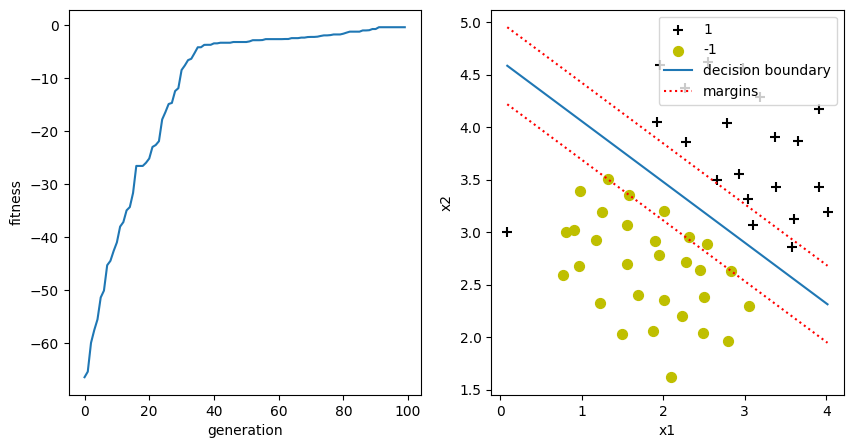

In [52]:
# define X and y as required by the fitness function
X=X1
y=y1
# execute the genetic algorithm
theta, fitness_history = run(fSVM, K, N, num_generations)

# print/plot the results
print(f'solution: theta = {theta}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(ax1)
plt.plot(fitness)
plt.xlabel('generation')
plt.ylabel('fitness')

plt.sca(ax2)
plotdata(X1, y1, theta)

We will now switch back the classification of that single data point. How does this affect your hyperplane?

In [53]:
y1[50] = 1
y = y1.copy()

In [54]:
# execute the genetic algorithm
theta_single, fitness_single = run(fSVM, K, N, num_generations)

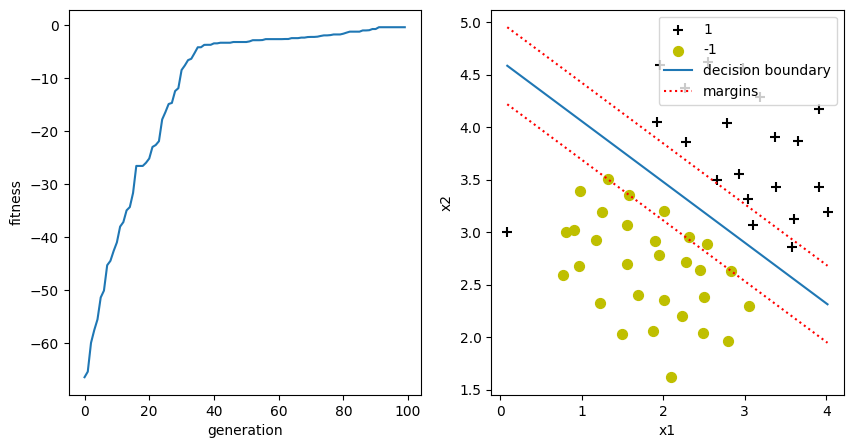

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(ax1)
plt.plot(fitness)
plt.xlabel('generation')
plt.ylabel('fitness')

plt.sca(ax2)
plotdata(X1, y1, theta)

#### Compare different values of C {1,10,100} and plot the boundaries. Use your run() function to determine the optimal theta's.

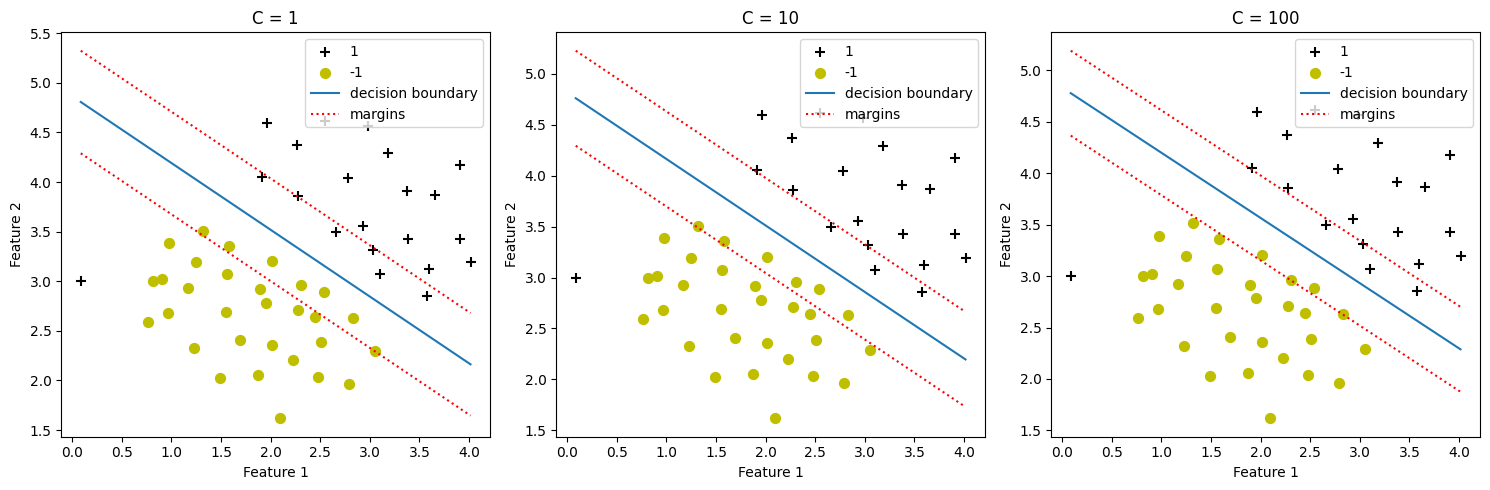

In [66]:
# Run minimusation for the 3 C values and plot the boundaries in a subplot with 3 windows. 

def plot_differentC():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    C_vals = [1, 10, 100]
    axes = [ax1, ax2, ax3]

    for i, C_val in enumerate(C_vals):
        theta_opt, fitness_history = run(fSVM, K, N, num_generations, C=C_val)
        ax = axes[i]
        
        plt.sca(ax)
        plotdata(X1, y1, theta_opt)
        
        ax.set_title(f"C = {C_val}")
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_differentC()


**Question.** Does the linear case work for C->0 and/or C->infinity work for the case that the dataset is not linearly separable? And what about the genetic code?
(set, e.g., the `X1[50,1] = 3` and `y1[50] = 1`)
How would you rephrase the genetic optimization such that you could use it for the non separable case as well?

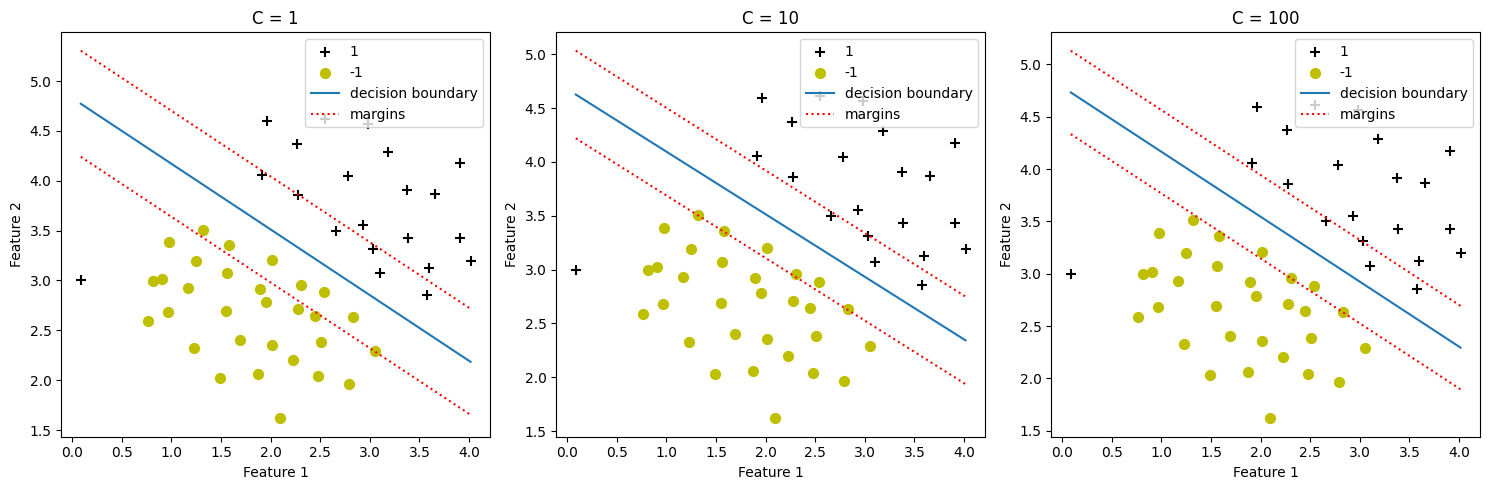

In [67]:
X1[50,1] = 3
y1[50] = 1

# Run minimusation for 3 C values and plot the boundaries in a subplot with 3 windows. 
plot_differentC()

## SVM with other Kernels **(5EC Mandatory, 3EC recommended)**

Below are two more data sets. Use the package sklearn for this. Dive into the manual of this package an figure out how you can get a good classifier. Explain how the methods works with other kernels. Change parameters, such as C, degree and other basis functions: what is their effect? 

Note the manual of sklearn tells me: '_Regularization parameter. The strength of the regularization is inversely proportional to C._ '

#### Example Dataset 2: Material Complexian

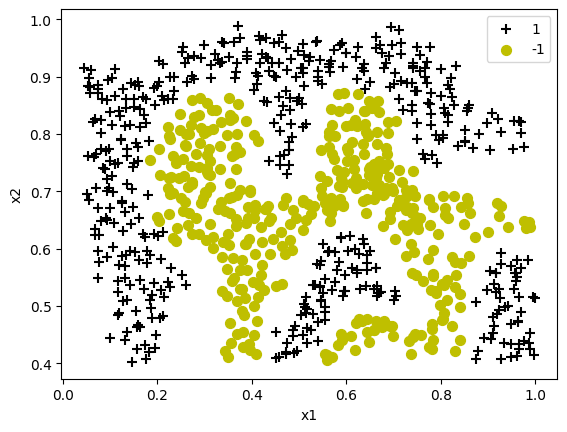

In [20]:
FILENAME = './SVMdata2.txt'  # points to the datafolder; either a relative or absolute path
DELIMITER = ','  # we use a lot of csv or txt files where the data is separated by a comma

data = np.loadtxt(FILENAME, delimiter=DELIMITER)
X2 = data[:,:2]
y2 = data[:,2]
plotdata(X2, y2)

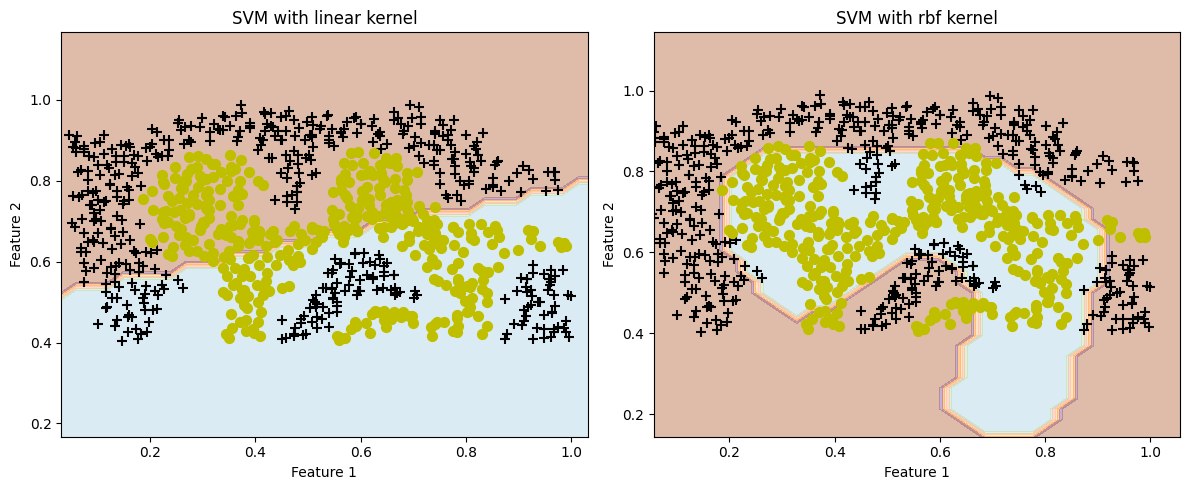

In [71]:
# Apply the sklearn tools to plot a decision boundary based on SVM with at least two different kernels
# Apply the sklearn tools to plot a decision boundary based on SVM with at least two different kernels
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

def plot_decboundary(X,y):
    kernels = ['linear', 'rbf']

    fig, axes = plt.subplots(1, len(kernels), figsize=(12, 5))
    for ax, kernel in zip(axes, kernels):
        clf = SVC(kernel=kernel)
        clf.fit(X, y)

        DecisionBoundaryDisplay.from_estimator(
            clf, X, alpha=0.4, ax=ax, cmap=plt.cm.Paired, response_method='predict'
        )
        #DecisionBoundaryDisplay.from_estimator(svc, X, ax=plt.gca(), alpha=0.4, cmap=plt.cm.Paired, response_method="predict")

        mask = y == 1
        ax.scatter(*X[mask,:].T, s=50, c='k', marker='+', label='1')
        ax.scatter(*X[~mask,:].T, s=50, c='y', marker='o', label='-1')
        #scatter = ax.scatter(X[:, 0], X[:, 1], c=y)
        sv_mean = clf.support_vectors_.mean(axis=0)
        span = 0.5  

        ax.set_xlim(sv_mean[0] - span, sv_mean[0] + span)
        ax.set_ylim(sv_mean[1] - span, sv_mean[1] + span)
        ax.set_title(f'SVM with {kernel} kernel')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')

    plt.tight_layout()
    plt.show()
    
plot_decboundary(X2,y2)

#### Example Dataset 3: Material Absurdian

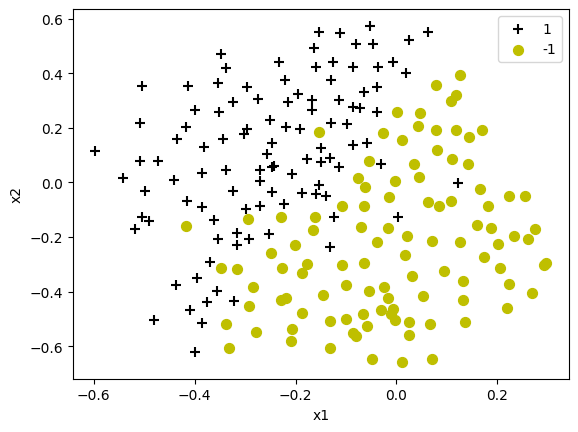

In [22]:
FILENAME = './SVMdata3.txt'  # points to the datafolder; either a relative or absolute path
DELIMITER = ','  # we use a lot of csv or txt files where the data is separated by a comma

data = np.loadtxt(FILENAME, delimiter=DELIMITER)
X3 = data[:,:2]
y3 = data[:,2]
plotdata(X3, y3)

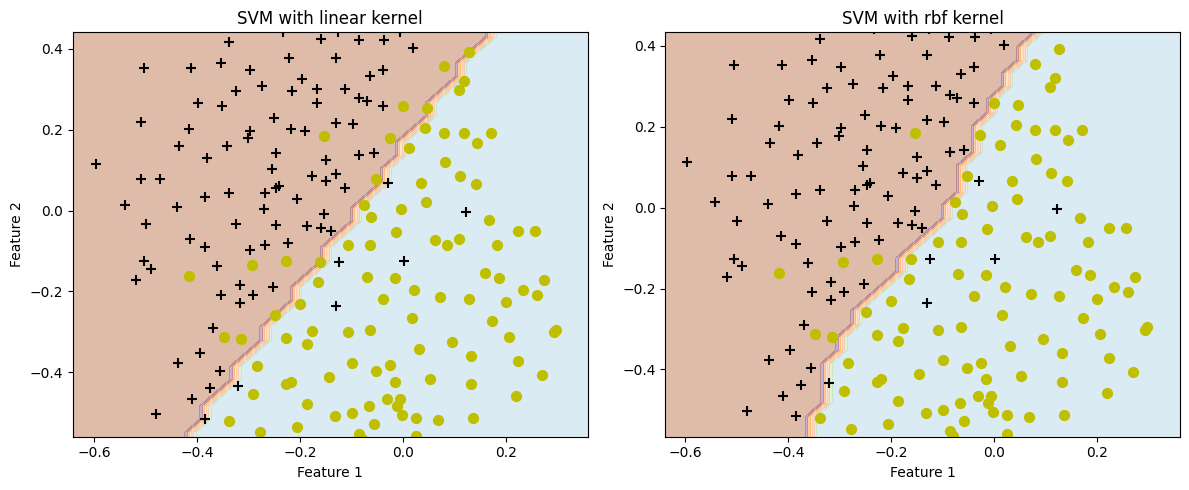

In [23]:
# Apply the sklearn tools to plot a decision boundary based on SVM with at least two different kernels

plot_decboundary(X3,y3)